In [1]:
from gigalens.jax.inference import ModellingSequence
from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.jax.profiles.light import sersic
from gigalens.jax.profiles.mass import epl, shear

import tensorflow_probability.substrates.jax as tfp
import jax
from jax import random
import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt
import optax
tfd = tfp.distributions

In [2]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(jnp.log(1.25), 0.25),
                gamma=tfd.TruncatedNormal(2, 0.25, 1, 3),
                e1=tfd.Normal(0, 0.1),
                e2=tfd.Normal(0, 0.1),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
            )
        ),
        tfd.JointDistributionNamed(
            dict(gamma1=tfd.Normal(0, 0.05), gamma2=tfd.Normal(0, 0.05))
        ),
    ]
)
lens_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(1.0), 0.15),
                n_sersic=tfd.Uniform(2, 6),
                e1=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                e2=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
                Ie=tfd.LogNormal(jnp.log(500.0), 0.3),
            )
        )
    ]
)

source_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.25), 0.15),
                n_sersic=tfd.Uniform(0.5, 4),
                e1=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.25),
                center_y=tfd.Normal(0, 0.25),
                Ie=tfd.LogNormal(jnp.log(150.0), 0.5),
            )
        )
    ]
)

prior = tfd.JointDistributionSequential(
    [lens_prior, lens_light_prior, source_light_prior]
)

In [3]:
kernel = np.load('./assets/psf.npy').astype(np.float32)
sim_config = SimulatorConfig(delta_pix=0.065, num_pix=60, supersample=2, kernel=kernel)
phys_model = PhysicalModel([epl.EPL(50), shear.Shear()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
observed_img = np.load('./assets/demo.npy')
prob_model = ForwardProbModel(prior, observed_img, background_rms=0.2, exp_time=100)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

In [4]:
schedule_fn = optax.polynomial_schedule(init_value=-1e-2, end_value=-1e-2/3, 
                                      power=0.5, transition_steps=500)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
map_estimate = model_seq.MAP(opt, seed=0)

  0%|          | 0/350 [00:00<?, ?it/s]

In [5]:
lps = prob_model.log_prob(LensSimulator(phys_model, sim_config, bs=500), map_estimate)[0]
best = map_estimate[jnp.argmax(lps)][jnp.newaxis,:]

In [6]:
schedule_fn = optax.polynomial_schedule(init_value=-1e-6, end_value=-3e-3, 
                                      power=2, transition_steps=300)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
qz, loss_hist = model_seq.SVI(best, opt, n_vi=1000, num_steps=1500)

  0%|          | 0/1500 [00:00<?, ?it/s]

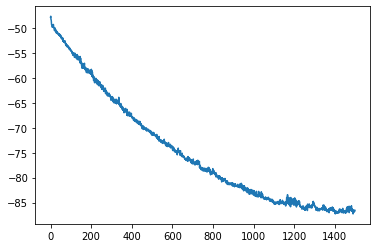

In [7]:
plt.plot(loss_hist)

In [8]:
samples = model_seq.HMC(qz, num_burnin_steps=250, num_results=750)

Sampling took 31.6s


In [9]:
rhat= tfp.mcmc.potential_scale_reduction(jnp.transpose(samples.all_states, (1,2,0,3)), independent_chain_ndims=2)

In [10]:
rhat

DeviceArray([1.0012666, 1.0019959, 1.0140201, 1.0129284, 1.0254885,
             1.0053424, 1.0170435, 1.0113335, 1.0016805, 1.0022913,
             1.0004947, 1.0006773, 1.0031064, 1.0009042, 1.0018313,
             1.0082303, 1.0118314, 1.0012192, 1.0250871, 1.0026639,
             1.0024301, 1.0076153], dtype=float32)

In [ ]:
prob_model.bij.forward(samples.all_states)

TypeError: If shallow structure is a sequence, input must also be a sequence. Input has type: <class 'jaxlib.xla_extension.pmap_lib.ShardedDeviceArray'>.
Entire first structure:
[., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., ., .]
Entire second structure:
.